# Authors: Yijun Wang, Owen Xu
# Datetime: 2020/02/14 8:42

# Assumption
### Assume homogeneous features across cities. Real life situations such as medical shortage that defers the time of confirm or even fail to confirm infectious individuals unevenly across cities would make the forecast biased. 
### Assume number of infectious on Jan 23, 2020 is equivalent to the confirm counts on Jan 23, 2020
### Assume that infected individuals were not infectious during the incubation period (Zhou, 2020)
### Assume close environment for each individual city
### Assume population growth and death rate are zero

# Parameter value
### Initial R0 takes the value of 3.0, while research varies from 2.2 to 3.8
### Current or trending R0 refers to model "Estimation of R0" at datetime 8:42 am 02-14-2020
### Wuhan population refers to https://baijiahao.baidu.com/s?id=1656943894281117716&wfr=spider&for=pc
### Beijing population refers to Beijing Population. (2019-05-12). Retrieved 2020-02-14, from http://worldpopulationreview.com/world-cities/beijing/
### Shanghai population refers to Shanghai Population. (2019-05-12). Retrieved 2020-02-14, from http://worldpopulationreview.com/world-cities/shanghai/

# Data
### API from BlankerL and data comes from Ding Xiang Yuan

# R0

In [3]:
# load data
import requests
import pandas as pd

url = 'https://lab.isaaclin.cn/nCoV/api/overall?latest=1'
r = requests.request('GET', url)
data = r.json()
df = pd.DataFrame.from_records(data['results'])
from datetime import datetime
import pandas

# date
df['t'] = pandas.to_datetime(df['updateTime']/1000,unit='s')
import datetime
df['date'] = df['t'].dt.date

# days: 疾病已爆发时间
import datetime
df['days'] = (df['updateTime']/1000 - datetime.datetime(2019,12,1,0,0,0).timestamp())/60/60/24

# generation time
Tg = 7.5
# calculate R0
import math
def R0Func(confirm, suspect,t):
    # confirm是确诊人数；susp是疑似人数；t是疾病已爆发时间
    # p为疑似病例转化为确诊病例的概率
    p = 0.695
    # infectious period
    Ti = 3
    # rho is the over incubation period over generation time
    rho = Ti/Tg
    # yt为实际预估感染人数
    yt = suspect * p + confirm
    # lamda为早期指数增长的增长率
    lamda = math.log(yt)/t    
    R0 = 1 + lamda * Tg + rho * (1 - rho) * pow(lamda * Tg,2)   
    return R0

df['R0'] = df.apply(lambda x: R0Func(x['confirmedCount'], x['suspectedCount'], x['days']), axis = 1)
df

,infectSource,passWay,dailyPic,dailyPics,summary,countRemark,currentConfirmedCount,confirmedCount,suspectedCount,curedCount,...,generalRemark,abroadRemark,marquee,quanguoTrendChart,hbFeiHbTrendChart,updateTime,t,date,days,R0
0,该字段已替换为说明2,该字段已替换为说明3,https://img1.dxycdn.com/2020/0211/763/33959988...,[https://img1.dxycdn.com/2020/0211/763/3395998...,,,55362,63755,13435,6906,...,疑似病例数来自国家卫健委数据，目前为全国数据，未分省市自治区等,,"[{'id': 366, 'marqueeLabel': '资讯', 'marqueeCon...",[{'imgUrl': 'https://img1.dxycdn.com/2020/0214...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0214...,1581640731619,2020-02-14 00:38:51.618999958,2020-02-14,75.36032,2.412749


# SEIR
### Setup

In [9]:
import scipy.integrate as spi
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# differential equations
def SEIR(inivalue, _):
    Y = np.zeros(4)
    X = inivalue
    # dS/dt
    Y[0] = - (beta * X[0] * X[2]) / N
    # dE/dt
    Y[1] = (beta * X[0] * X[2]) / N - X[1] / Tg
    # dI/dt
    Y[2] = X[1] / Tg - gamma * X[2]
    # dR/dt
    Y[3] = gamma * X[2]
    return Y
# T为传播时间
T = 400
Time = np.arange(0, T + 1)
# R0 is basic reproduction number
from pandas import DataFrame
R0 = df.iloc[len(df)-1,df.shape[1]-1]
# beta is effective contact rate 
def betaFunc(R0 = R0, Tg = Tg):
    return R0/Tg
# gamma is removal rate
def gammaFunc(Tg = Tg):
    return 1/Tg
gamma = gammaFunc()
# create dates
from datetime import date
import datetime
start_day = date(2020, 1, 23)
dates = [start_day + datetime.timedelta(n) for n in range(T + 1)]

# Wuhan Pre-Intervention

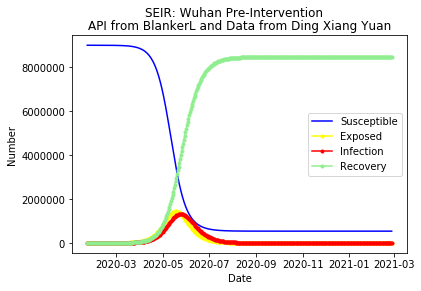

3.0 0.4 1320114.2066012942 123 2020-05-25


In [10]:
# N is total population: 9million left in town
N = 9000000
# I_0为感染者的初始人数
I_0 = 86
# E_0为潜伏者的初始人数
E_0 = 0
# R_0为治愈者的初始人数
R_0 = 0
# S_0为易感者的初始人数
S_0 = N - I_0 - E_0 - R_0
# INI为初始状态下的数组
INI = (S_0, E_0, I_0, R_0)
# R0 is basic reproduction number
R0_ini = 3.0
# beta is effective contact rate
beta = betaFunc(R0_ini)
# solve the system of differential equations
RES = spi.odeint(SEIR, INI, Time)

plt.plot(dates, RES[:,0],color = 'blue',label = 'Susceptible')
plt.plot(dates, RES[:,1],color = 'yellow',label = 'Exposed',marker = '.')
plt.plot(dates, RES[:,2],color = 'red',label = 'Infection',marker = '.')
plt.plot(dates, RES[:,3],color = 'lightgreen',label = 'Recovery',marker = '.')

plt.title('API from BlankerL and Data from Ding Xiang Yuan')
plt.suptitle('SEIR Forecast: Wuhan Pre-Intervention')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number')
plt.show()

print(R0_ini, beta, max(RES[:,2]),np.argmax(RES[:,2]), date(2020,1,23) + datetime.timedelta(int(np.argmax(RES[:,2]))))

### If no intervention is implemented, Wuhan will have 1320114 people to be infected at the peak point on May 25, 2020

# Wuhan Trending

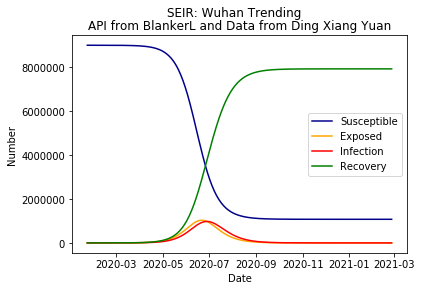

2.412749316775526 0.3216999089034035 977533.6639731781 157 2020-06-28


In [11]:
# R0 is basic reproduction number
from pandas import DataFrame
R0 = df.iloc[len(df)-1,df.shape[1]-1]
# beta is effective contact rate
beta = betaFunc(R0)
# solve the system of differential equations
RES = spi.odeint(SEIR, INI, Time)

plt.plot(dates, RES[:,0],color = 'darkblue',label = 'Susceptible')
plt.plot(dates, RES[:,1],color = 'orange',label = 'Exposed')
plt.plot(dates, RES[:,2],color = 'red',label = 'Infection')
plt.plot(dates, RES[:,3],color = 'green',label = 'Recovery')

plt.title('API from BlankerL and Data from Ding Xiang Yuan')
plt.suptitle('SEIR Forecast: Wuhan Trending')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number')
plt.show()

print(R0, beta, max(RES[:,2]),np.argmax(RES[:,2]), date(2020,1,23) + datetime.timedelta(int(np.argmax(RES[:,2]))))

### If the current situation continues, Wuhan will have 977533  people to be infected at the peak point in June 28, 2020

# Guangzhou Pre-Intervention
### 7 infectious people on 1/23/2020

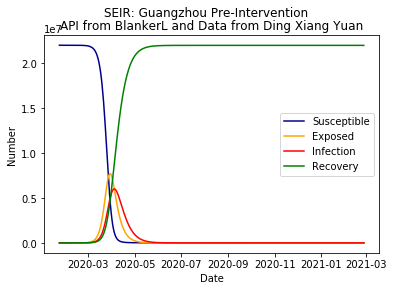

0.4 6012503.633629942 72 2020-04-04


In [36]:
beta = betaFunc(R0_ini)
INI = (22000000, 0, 7, 0)
RES = spi.odeint(SEIR, INI, Time)
plt.plot(dates, RES[:,0],color = 'darkblue',label = 'Susceptible')
plt.plot(dates, RES[:,1],color = 'orange',label = 'Exposed')
plt.plot(dates, RES[:,2],color = 'red',label = 'Infection')
plt.plot(dates, RES[:,3],color = 'green',label = 'Recovery')

plt.title('API from BlankerL and Data from Ding Xiang Yuan')
plt.suptitle('SEIR: Guangzhou Pre-Intervention')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number')
plt.show()

print(beta, max(RES[:,2]),np.argmax(RES[:,2]), date(2020,1,23) + datetime.timedelta(int(np.argmax(RES[:,2]))))

### 6012503 infectous at the peak point on April 4, 2020

# Guangzhou Trending

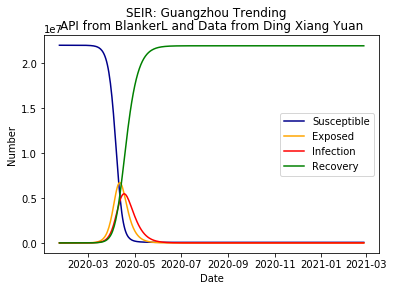

2.412749316775526 0.3216999089034035 5466924.456657225 85 2020-04-17


In [37]:
R0 = df.iloc[len(df)-1,df.shape[1]-1]
beta = betaFunc(R0)
RES = spi.odeint(SEIR, INI, Time)

plt.plot(dates, RES[:,0],color = 'darkblue',label = 'Susceptible')
plt.plot(dates, RES[:,1],color = 'orange',label = 'Exposed')
plt.plot(dates, RES[:,2],color = 'red',label = 'Infection')
plt.plot(dates, RES[:,3],color = 'green',label = 'Recovery')

plt.title('API from BlankerL and Data from Ding Xiang Yuan')
plt.suptitle('API from BlankerL and Data from Ding Xiang Yuan')
plt.suptitle('SEIR: Guangzhou Trending')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number')
plt.show()

print(R0, beta, max(RES[:,2]),np.argmax(RES[:,2]), date(2020,1,23) + datetime.timedelta(int(np.argmax(RES[:,2]))))

# Qingdao Pre-Intervention

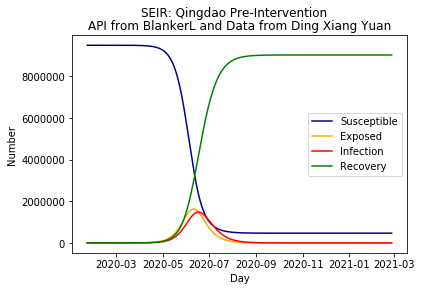

2.412749316775526 0.4 1481651.49835015 146 2020-06-17


In [38]:
beta = betaFunc(R0_ini, Tg)
INI = (9500000, 0, 4, 0)
RES = spi.odeint(SEIR, INI, Time)
plt.plot(dates, RES[:,0],color = 'darkblue',label = 'Susceptible')
plt.plot(dates, RES[:,1],color = 'orange',label = 'Exposed')
plt.plot(dates, RES[:,2],color = 'red',label = 'Infection')
plt.plot(dates, RES[:,3],color = 'green',label = 'Recovery')

plt.title('API from BlankerL and Data from Ding Xiang Yuan')
plt.suptitle('SEIR: Qingdao Pre-Intervention')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Number')
plt.show()

print(R0, beta, max(RES[:,2]),np.argmax(RES[:,2]), date(2020,1,23) + datetime.timedelta(int(np.argmax(RES[:,2]))))

# Qingdao Trending

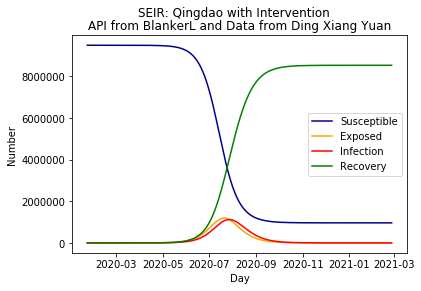

2.412749316775526 0.3216999089034035 1121987.2515156318 187 2020-07-28


In [39]:
beta = betaFunc(R0, Tg)
INI = (9500000, 0, 4, 0)
RES = spi.odeint(SEIR, INI, Time)

plt.plot(dates, RES[:,0],color = 'darkblue',label = 'Susceptible')
plt.plot(dates, RES[:,1],color = 'orange',label = 'Exposed')
plt.plot(dates, RES[:,2],color = 'red',label = 'Infection')
plt.plot(dates, RES[:,3],color = 'green',label = 'Recovery')

plt.title('API from BlankerL and Data from Ding Xiang Yuan')
plt.suptitle('SEIR: Qingdao with Intervention')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Number')
plt.show()

print(R0, beta, max(RES[:,2]),np.argmax(RES[:,2]), date(2020,1,23) + datetime.timedelta(int(np.argmax(RES[:,2]))))

# Beijing Pre-Intervention

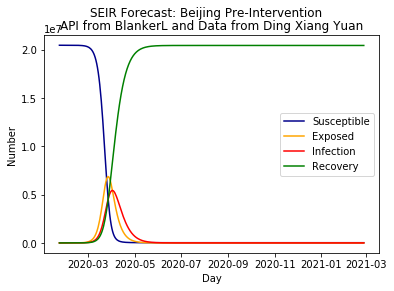

2.412749316775526 0.4 5429208.513301973 70 2020-04-02


In [40]:
beta = betaFunc(R0_ini, Tg)
INI = (20462610, 0, 26, 0)
RES = spi.odeint(SEIR, INI, Time)
plt.plot(dates, RES[:,0],color = 'darkblue',label = 'Susceptible')
plt.plot(dates, RES[:,1],color = 'orange',label = 'Exposed')
plt.plot(dates, RES[:,2],color = 'red',label = 'Infection')
plt.plot(dates, RES[:,3],color = 'green',label = 'Recovery')

plt.title('API from BlankerL and Data from Ding Xiang Yuan')
plt.suptitle('SEIR Forecast: Beijing Pre-Intervention')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Number')
plt.show()

print(R0, beta, max(RES[:,2]),np.argmax(RES[:,2]), date(2020,1,23) + datetime.timedelta(int(np.argmax(RES[:,2]))))

# Beijing Trending

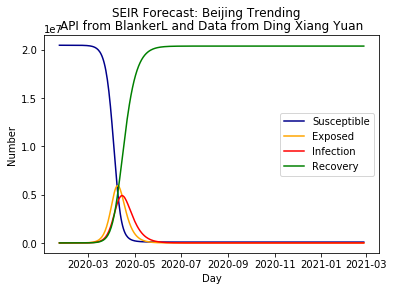

0.3216999089034035 4894878.493843867 82 2020-04-14


In [41]:
beta = betaFunc(R0, Tg)
INI = (20462610, 0, 26, 0)
RES = spi.odeint(SEIR, INI, Time)

plt.plot(dates, RES[:,0],color = 'darkblue',label = 'Susceptible')
plt.plot(dates, RES[:,1],color = 'orange',label = 'Exposed')
plt.plot(dates, RES[:,2],color = 'red',label = 'Infection')
plt.plot(dates, RES[:,3],color = 'green',label = 'Recovery')

plt.title('API from BlankerL and Data from Ding Xiang Yuan')
plt.suptitle('SEIR Forecast: Beijing Trending')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Number')
plt.show()

print(beta, max(RES[:,2]),np.argmax(RES[:,2]), date(2020,1,23) + datetime.timedelta(int(np.argmax(RES[:,2]))))

# Shantou Pre-Intervention

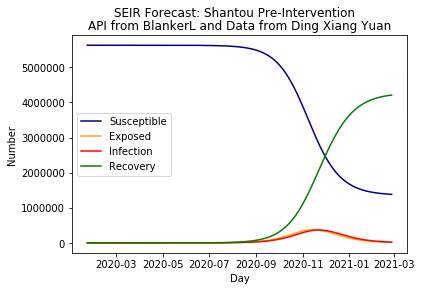

0.4 368044.5321398076 304 2020-11-22


In [42]:
beta = betaFunc(R0_ini, Tg)
INI = (5630000, 0, 1, 0)
RES = spi.odeint(SEIR, INI, Time)

plt.plot(dates, RES[:,0],color = 'darkblue',label = 'Susceptible')
plt.plot(dates, RES[:,1],color = 'orange',label = 'Exposed')
plt.plot(dates, RES[:,2],color = 'red',label = 'Infection')
plt.plot(dates, RES[:,3],color = 'green',label = 'Recovery')

plt.title('API from BlankerL and Data from Ding Xiang Yuan')
plt.suptitle('SEIR Forecast: Shantou Pre-Intervention')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Number')
plt.show()

print(beta, max(RES[:,2]),np.argmax(RES[:,2]), date(2020,1,23) + datetime.timedelta(int(np.argmax(RES[:,2]))))

# Shantou Intervention

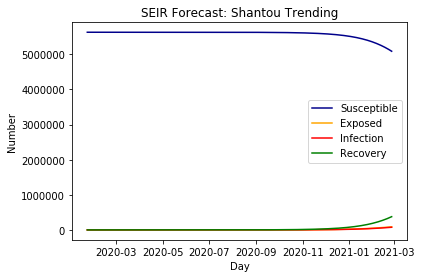

0.3216999089034035 75564.5278855332 400 2021-02-26


In [43]:
beta = betaFunc(R0, Tg)
INI = (5630000, 0, 1, 0)
RES = spi.odeint(SEIR, INI, Time)

plt.plot(dates, RES[:,0],color = 'darkblue',label = 'Susceptible')
plt.plot(dates, RES[:,1],color = 'orange',label = 'Exposed')
plt.plot(dates, RES[:,2],color = 'red',label = 'Infection')
plt.plot(dates, RES[:,3],color = 'green',label = 'Recovery')

plt.title('API from BlankerL and Data from Ding Xiang Yuan')
plt.title('SEIR Forecast: Shantou Trending')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Number')
plt.show()

print(beta, max(RES[:,2]),np.argmax(RES[:,2]), date(2020,1,23) + datetime.timedelta(int(np.argmax(RES[:,2]))))

# Shanghai Pre-Intervention

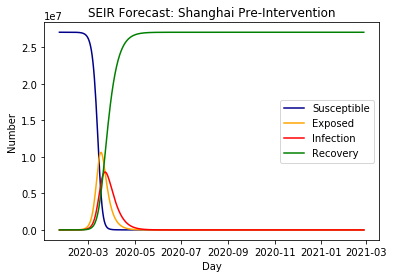

0.4 7929547.779058558 60 2020-03-23


In [33]:
beta = betaFunc(R0_ini, Tg)
INI = (27058479, 0, 16, 0)
RES = spi.odeint(SEIR, INI, Time)

plt.plot(dates, RES[:,0],color = 'darkblue',label = 'Susceptible')
plt.plot(dates, RES[:,1],color = 'orange',label = 'Exposed')
plt.plot(dates, RES[:,2],color = 'red',label = 'Infection')
plt.plot(dates, RES[:,3],color = 'green',label = 'Recovery')

plt.title('API from BlankerL and Data from Ding Xiang Yuan')
plt.suptitle('SEIR Forecast: Shanghai Pre-Intervention')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Number')
plt.show()

print(beta, max(RES[:,2]),np.argmax(RES[:,2]), date(2020,1,23) + datetime.timedelta(int(np.argmax(RES[:,2]))))

# Shanghai Trending

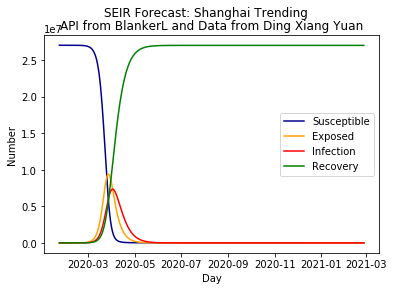

0.3216999089034035 7364215.38402189 70 2020-04-02


In [44]:
beta = betaFunc(R0, Tg)
INI = (27058479, 0, 16, 0)
RES = spi.odeint(SEIR, INI, Time)

plt.plot(dates, RES[:,0],color = 'darkblue',label = 'Susceptible')
plt.plot(dates, RES[:,1],color = 'orange',label = 'Exposed')
plt.plot(dates, RES[:,2],color = 'red',label = 'Infection')
plt.plot(dates, RES[:,3],color = 'green',label = 'Recovery')

plt.title('API from BlankerL and Data from Ding Xiang Yuan')
plt.suptitle('SEIR Forecast: Shanghai Trending')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Number')
plt.show()

print(beta, max(RES[:,2]),np.argmax(RES[:,2]), date(2020,1,23) + datetime.timedelta(int(np.argmax(RES[:,2]))))